# Vérification du codage des lois de paroi turbulentes CMFD

In [1]:
from trustutils import run 
from trustutils.jupyter import plot
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['text.usetex'] = False
import copy
import os, sys
from string import Template
import time
from IPython.display import display
import math

run.introduction("C. Reiss","16/03/2022")

run.TRUST_parameters()

## Introduction 
 Validation made by : C. Reiss



 Report created : 16/03/2022



 Report generated 20/03/2023

### TRUST parameters 
 * Version TRUST: 1.9.2_beta
 * Binary used: /volatile/catB/cr268029/triocfd/Multiphase/CMFD/CMFD_opt (built in directory /volatile/catB/cr268029/triocfd/Multiphase/CMFD/share/Validation/Rapports_automatiques/Verification_wall_laws/build)

## Description
### Validation des lois de paroi implementees dans trioCMFD

On fait un pas de temps sur un canal long dans la direction de $y$. La condition initiale de vitesse est $v_x=0$, $v_y=1$, $v_z=0$. Par consequent, a une même distance du bord, on a une variation de $y_+$ car on a une variation de $u_{\parallel}$. On calcule analytiquement $u_\tau$, $k_+$, $\tau_+$, $\omega_+$ et $\theta_+$ en fonction de $y_+$. On prend une sonde de la valeur des operateurs de diffusion le long du canal. On verifie que les valeurs de $k_+$, $\theta_+$, $\tau_+$, $\omega_+$ et le taux de cisaillement calculees par triocfd et injectees par les lois de paroi dans les operateurs de diffusion de la vitesse, de la temperature et des quantites turbulentes correspondent aux valeurs analytiques.

In [14]:
configs = ["PolyMAC_tau_fixe_k_fixe","PolyMAC_omega_dix_k_simple", "PolyMAC_omega_demi_k_complique"]
equation = ["echelle_temporelle_turbulente"]+["taux_dissipation_turbulent"]*2
diffusion = [ "k_tau"]+["k_omega"]*2
diss =         ["tau"]+['omega']*2
diss_ext = ["tau_ext"]+["omega_ext"]*2
IC_diss  = ["0.7"]+[str(1/0.7)]*2
CL_diss = ["scalaire_impose_paroi champ_front_uniforme 1 0 ", "Cond_lim_omega_dix { } ", "Cond_lim_omega_demi { }  "]
CL_k = ["scalaire_impose_paroi champ_front_uniforme 1 0 ", "Cond_lim_k_simple_flux_nul ", "Cond_lim_k_complique_transition_flux_nul_demi  "]
polyedriser = ["Polyedriser dom"]
schema = ["PolyMAC_P0"]

#Create the calculation cases

force_recalculation = True

def GenerateInputFile(name,substitutions_dict):
    with open(f"build/jdd.data", "r") as file: 
        filedata = Template(file.read())
    result = filedata.substitute(substitutions_dict)
    with open(f"build/{name}.data", "w") as file:
        file.write(result)

if force_recalculation or not os.path.exists('build'):
    print('Recalculation running..')
    run.reset()
    run.defaultSuite_ = run.TRUSTSuite(runPrepare=False)

    for c in range(len(configs)) :
        print(f"Adding the launch files for {configs[c]}")
        folder_run = f"{configs[c]}"
        os.system(f'mkdir build/{folder_run}')
            
        name_run = f"{folder_run}"

        substitutions_dict = {"diffusion" : diffusion[c] ,
                              "diss": diss[c],
                              "diss_ext": diss_ext[c],                                  
                              "IC_diss" : IC_diss[c] ,
                              "CL_diss" : CL_diss[c] ,
                              "CL_k" : CL_k[c] ,
                              "equation" : equation[c],
                              "polyedriser" : polyedriser[0] ,
                              "schema" : schema[0]
                             }
        GenerateInputFile(name_run,substitutions_dict)

        os.system(f'mv build/{name_run}.data build/{folder_run}')
        run.addCase(f"./{folder_run}", f"{name_run}.data")
    
    run.runCases()
    display(run.tablePerf())


## Raw extracts from TrioCFD calculation

In [3]:
# Relevant quantities

mu = 2.3
rho = 3.4
lambd = 4.8
Cp = 2.7
nu = mu/rho
B_w = 0.075
B_k = 0.09

k_init = 3.1
tau_init = 0.7
omega_init = 1/0.7

nuT = lambd/(rho*Cp) + 0.67*k_init*tau_init
nuk=nu + 0.67*k_init*tau_init
nudiss = nu + 0.5*k_init*tau_init

deltaT = 4.8

z = 0.5
Pr = mu*Cp/lambd

surface_face = 1
volume_elem = 1


In [4]:
von_karman_ = 0.41
limiteur_y_p = 0.01

def calc_u_tau_loc(y, u_par, nu):
    eps = 1.e-3
    iter_max = 20
    n_iter = 0

    u_tau_1 = 1.
    while to_zero(y, u_tau_1, u_par, nu) < 0 :
        u_tau_1 *= 10
    u_tau_0 = 0.1
    while to_zero(y,  u_tau_0, u_par, nu) > 0 :
        u_tau_0 /= 10
    if u_tau_1 == 1 :
        u_tau_1 = u_tau_0*10
    elif u_tau_0 == 0.1 :
        u_tau_0 = u_tau_1/10
    
    eps = u_tau_0 * eps

    while (abs(u_tau_1-u_tau_0)>eps) and (n_iter <= iter_max):
        f_0 = to_zero(y, (u_tau_0+u_tau_1)/2, u_par, nu)
        if f_0 > 0 :
            u_tau_1 -= (u_tau_1-u_tau_0)/2
        else :
            u_tau_0 += (u_tau_1-u_tau_0)/2
        n_iter+=1

    return u_tau_0

def to_zero(y, u_tau,u_par, nu) :
    y_p = y*u_tau/nu
    return u_plus_de_y_plus(y_p) - u_par/u_tau

def u_plus_de_y_plus( y_p) :
    reichardt = np.log(1+0.4*y_p)/von_karman_
    reichardt += 7.8
    reichardt += -7.8*np.exp(-y_p/11)
    reichardt += -7.8*y_p/11*np.exp(-y_p/3)

    log_law = np.log(y_p)/von_karman_ + 5.1

    blending = np.tanh( y_p/27*y_p/27*y_p/27*y_p/27)

    return (1-blending)*reichardt + blending*log_law

def theta_plus_de_y_plus(y_p) :
    Gamma = 0.01*(Pr*y_p)**4/(1+5*Pr**3*y_p)
    B = (3.85*Pr**(1/3)-1.3)**2+2.12*np.log(Pr)
    return Pr*y_p*np.exp(-Gamma) + (2.12*np.log(1+y_p)+B)*np.exp(-1/Gamma)

def omega_plus_de_y_plus(y_p) :
    arg = y_p/10
    phi = np.tanh(arg**4)
    w_vis_p = 6/(B_w*y_p**2)
    w_log_p = 1/(B_k**0.5*von_karman_*y_p)
    w_1_p = w_vis_p+w_log_p
    w_2_p = (w_vis_p**1.2+w_log_p**1.2)**(1/1.2)
    return phi * w_1_p + (1-phi)*w_2_p

def k_plus_de_y_plus(y_p) :
    f1 = (y_p-1) *(y_p-1)*(y_p-1)/30
    f2 = 1/np.sqrt(B_k)-.08* abs(4.6 - np.log(y_p))**3
    b1 = np.tanh((y_p/4.)**10)
    b2 = np.tanh((y_p/2500.)**1.4)
    f3 = 1/np.sqrt(B_k)*.25
    return np.maximum((1-b1)*f1 + b1*f2, 0)*(1-b2)+b2*f3


In [9]:

absc = np.linspace(0.5,1999.5, 2000)
ut = np.array([calc_u_tau_loc(z, v, nu) for v in absc])
yp = np.array([utl * z/nu for utl in ut])
up = np.array([u_plus_de_y_plus(ypl) for ypl in yp])
Tp = np.array([theta_plus_de_y_plus(ypl) for ypl in yp])

frott_th = -ut*ut*rho
qth = rho*Cp*ut*(5.8-1)/Tp

k_th =  [(0-k_init) * nuk / z * yp/yp]
k_th += [(0-k_init) * nuk / z * (1-np.tanh( yp**2/100 ) )]
k_th += [ (ut*ut*k_plus_de_y_plus(yp/2)-k_init)*2.*nuk/z * ( 1 - np.tanh(( yp/50.)**3)) ]

diss_th = []
diss_th += [ -tau_init * nudiss / z * yp/yp]
diss_th += [ (10*nu*6/(B_w*z**2) - omega_init) * nudiss / z * yp/yp]
diss_th += [ (2*ut*ut/nu*omega_plus_de_y_plus(yp/2)-ut*ut/nu*omega_plus_de_y_plus(yp) - omega_init) * nudiss / z ]


OSError: PolyMAC_tau_fixe_k_fixe/PolyMAC_tau_fixe_k_fixe_YP.son not found.

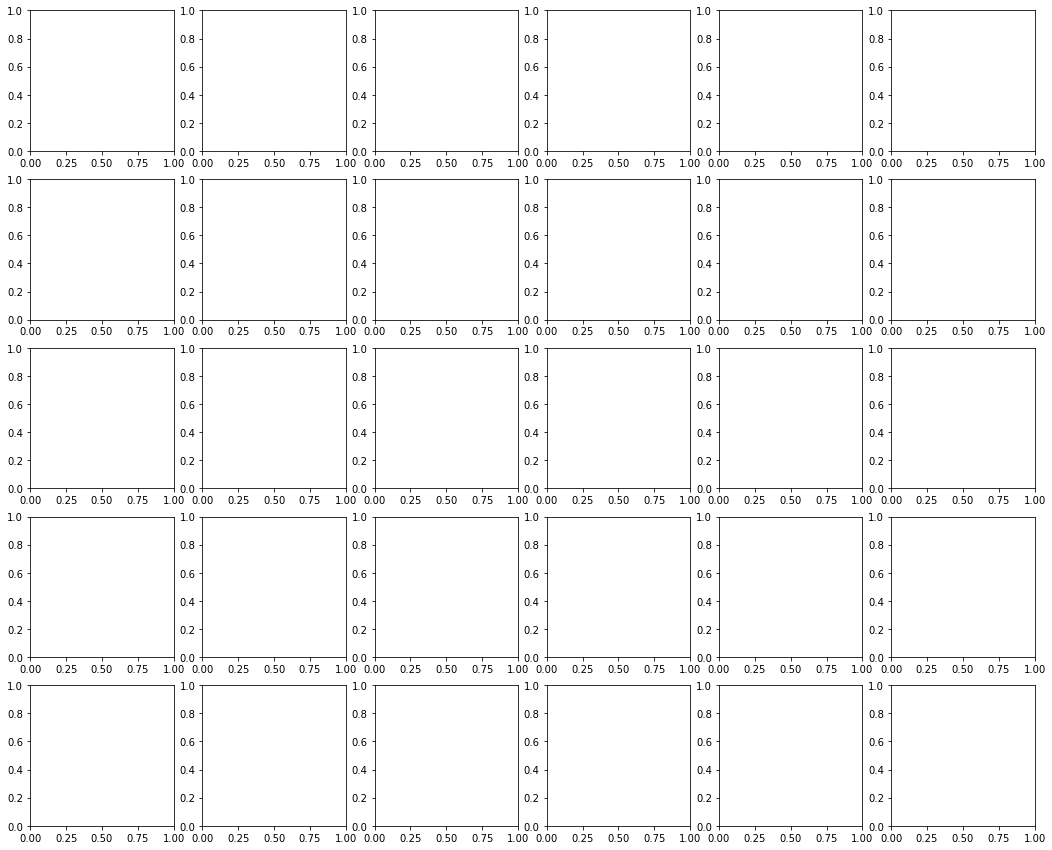

In [15]:

fig = plt.figure(figsize = (18, 15))
axs = fig.subplots(5, 6)

for c in range(len(configs)) :
    folder_run = configs[c]

    yptr = np.array(plot.loadText(f"{folder_run}/{folder_run}_YP.son")[1::,-1])
    vx = np.array(plot.loadText(f"{folder_run}/{folder_run}_VITESSEY.son")[1::,0])
    diffvitx = np.array(plot.loadText(f"{folder_run}/{folder_run}_DIFF_VIT.son")[2::3,1])
    diffk = np.array(plot.loadText(f"{folder_run}/{folder_run}_DIFF_K.son")[1::,-1])
    diffdiss=np.array(plot.loadText(f"{folder_run}/{folder_run}_DIFF_DISS.son")[1::,-1])
    diffT = np.array(plot.loadText(f"{folder_run}/{folder_run}_DIFF_T.son")[1::,-1])

    axs[0,  c].plot(absc, yptr, "b-", label = "TRUST")
    axs[0,  c].plot(absc, yp, "k--", label = "Theory")
    axs[1,  c].plot(yp, diffvitx*rho, "b-", label = "TRUST")
    axs[1,  c].plot(yp, frott_th, "k--", label = "Theory")
    axs[2,  c].plot(yp, diffk*rho, "b-", label = "TRUST")
    axs[2,  c].plot(yp, k_th[c]*rho, "k--", label = "Theory")
    axs[3,  c].plot(yp, diffdiss, "b-", label = "TRUST")
    axs[3,  c].plot(yp, diss_th[c], "k--", label = "Theory")
    axs[4,  c].plot(yp, diffT*rho*Cp, "b-", label = "TRUST")
    axs[4,  c].plot(yp, qth, "k--", label = "Theory")

    axs[0,  c].set_ylabel("y+")
    axs[1,  c].set_ylabel("Velocity flux")
    axs[2,  c].set_ylabel("k flux")
    axs[3,  c].set_ylabel(f"{diss[c]} flux")
    axs[4,  c].set_ylabel("Heat flux (W/m2)")

    axs[0,  c].set_title(folder_run)
    axs[0,  c].set_xlabel("Velocity")

    for i in range(1, 5):
        axs[i,  c].set_title(folder_run)
        axs[i,  c].set_xlabel("y+")

axs[2, 0].set_ylim( -45, -44.8)
axs[3, 0].set_ylim(-2.5, -2.4)
axs[3, 1].set_ylim(7000, 8000)

plt.tight_layout()
plt.savefig("Verification_wall_laws.pdf")